In [12]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
# from utilities2015 import *
# from metadata import *
# from data_manager import *
from annotation_utilities import *
# from registration_utilities import *
# from conversion import *
from vis3d_utilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import xml.etree.ElementTree as ET

def get_stacy_contours(stack):
    """
    Returns:
        (dict {str: list of (n,3)-arrays}, dict {str: (n,3)-array}): contours, markers
    """

#     xmlfile = '/shared/stacy_data/%s.xml' % stack
    xmlfile = '/home/yuncong/stacy_data/%s.xml' % stack
    download_from_s3(xmlfile)

    # create element tree object
    tree = ET.parse(xmlfile)

    # get root element
    root = tree.getroot()

    prefix = '{http://www.mbfbioscience.com/2007/neurolucida}'

    # neurolucida_name_map = \
    # {"Contour Name 1": 'RMC',
    # "Contour Name 2": '3N',
    # "Contour Name 3": 'fr',
    # 'Brain': 'outerContour',
    #  'SNR': 'SNR'}

    neurolucida_name_map = \
    {"IO": 'IO_L',
    "LRT": 'LRt_L',
    # "BRAINSTEM": 'brainstem',
    '5 MOTOR': '5N_L',
     '7n': '7n_L',
    'AMB MOTOR': 'Amb_L',
    'FACIAL MOTOR': '7N_L',
     'SpVC': 'Sp5C_L',
     'SpVO': 'Sp5O_L',
     'Sp5I': 'Sp5I_L',
     'Pr5': 'Pr5_L',
     'Sol': 'Sol_L',
     'Li': 'Li_L',
    #  'SpVIO': 'unknown',
    'R LrT': 'LRt_R',
    'R FN':  '7N_R',
    'R_7n': '7n_R',
    'R 5N':  '5N_R',
    'R SpVC': 'Sp5C_R',
    'R Sp5I': 'Sp5I_R',
    'R SpVO': 'Sp5O_R',
    'R Pr5':  'Pr5_R',
    'R IO':  'IO_R',
     'R-SpVI':  'Sp5I_R',
    'R-SpV':  'Sp5_R',
    'R-SpVO':  'Sp5O_R',
     'R-PrV':  'Pr5_R',
     'R-Amb':  'Amb_R',
    #  'R SpVIO':  'unknown',
     'SpVC_R':  'Sp5C_R',
     'R 5M':  '5N_R',
    #  'User Line 5':  'unknown',
    #  'NewContour': 'unknown',
    #   'User Line 2':  'unknown',
    }

    contours = defaultdict(list)

    for item in root.findall(prefix+'contour'):
        name = item.attrib['name']
        if name not in neurolucida_name_map:
    #         raise Exception('Name %s in stack %s not recognized' % (name, stack))
            sys.stderr.write('Name %s in stack %s not recognized. Ignored.\n' % (name, stack))
            continue
        name = neurolucida_name_map[name]
        curr_contour = []
    #     try:
    #         resolution = float(item.findall(prefix+'resolution')[0].text)
    #         print resolution
    #     except:
    #         pass
        for p in item.findall(prefix+'point'):
            curr_contour.append((float(p.attrib['x']), float(p.attrib['y']), float(p.attrib['z'])))
        contours[name].append(np.array(curr_contour))

    contours.default_factory = None

    #################

    # structure_subset = ['3N_L', 'RMC_L', 'SNR_L']
    structure_subset = \
    [name for name in contours.keys() if parse_label(name)[0] in all_known_structures]
    print structure_subset

    ####################

    downscale = 32

    if stack == 'RV4_67hrs' or stack == 'RV19_61hrs' or stack == 'RV9_53hrs':
        contours_orientationCorrected = {name_u: [cnt*[1,-1,1]
                                         for cnt in cnts3d if len(cnt) > 2] 
                               for name_u, cnts3d in contours.iteritems()}
    else:
        contours_orientationCorrected = {name_u: [cnt*[-1,-1,1]
                                         for cnt in cnts3d] 
                               for name_u, cnts3d in contours.iteritems()}

    contours_atlasResol = {name: [cnt / (XY_PIXEL_DISTANCE_LOSSLESS * downscale)
                                    for cnt in cnts3d] 
                           for name, cnts3d in contours_orientationCorrected.iteritems()
                                                if name in structure_subset}

    
    #####################
    
    markers = defaultdict(list)
#     markers = {}

    for item in root.findall(prefix+'marker'):
        curr_markers = []
        for p in item.findall(prefix+'point'):
            curr_markers.append((float(p.attrib['x']), float(p.attrib['y']), float(p.attrib['z'])))
        name = '7N_R'
        markers[name].append(np.array(curr_markers))
        
    markers = {name: np.concatenate(mkr_lists) for name, mkr_lists in markers.iteritems()}

    # markers.default_factory = None
    
    #########################
    
    if stack == 'RV4_67hrs' or stack == 'RV19_61hrs' or stack == 'RV9_53hrs':

        markers_orientationCorrected = {name_u: mkrs3d*[1,-1,1]
                               for name_u, mkrs3d in markers.iteritems()}

    else:
        markers_orientationCorrected = {name_u: mkrs3d*[-1,-1,1]
                           for name_u, mkrs3d in markers.iteritems()}

    markers_atlasResol = {name: mkrs3d / (XY_PIXEL_DISTANCE_LOSSLESS * downscale)
                           for name, mkrs3d in markers_orientationCorrected.iteritems()
                         if name in structure_subset}
    
    
    return contours_atlasResol, markers_atlasResol

In [14]:
stack_fixed = 'RV4_67hrs'
stack_moving = 'RV14_65hrs'
# stack_moving = 'RV13_64hrs'
# stack_moving = 'RV19_61hrs'

stacks_to_colors = {'RV4_67hrs': (1,0,0), 'RV14_65hrs': (0,1,0), 'RV19_61hrs': (0,0,1), 'RV13_64hrs': (1,1,0)}

In [15]:
contours_f_rel2world, markers_f_rel2world = get_stacy_contours(stack_fixed)
contours_m_rel2world, markers_m_rel2world = get_stacy_contours(stack_moving)

Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignore

['LRt_R', 'Sp5I_R', '7N_R', 'Sp5C_L', 'Sp5I_L', '7n_R', '5N_R', '5N_L', '7n_L', '7N_L', 'Sp5C_R', 'Sp5O_R', 'Sp5O_L', 'LRt_L']
['Sp5O_R', 'Sp5I_R', 'Sp5C_L', '7N_R', '5N_R', '5N_L', '7N_L', 'Sp5C_R', '7n_L', 'Amb_R', '7n_R', 'Amb_L', 'LRt_R', 'LRt_L']


Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name SpVIO in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name SpVIO in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name SpVIO in stack RV14_65hrs not recognized. I

In [16]:
contours_f_rel2world

{'5N_L': [array([[ 1216.43070652,   550.18206522,    44.83695652],
         [ 1205.53600543,   545.25883152,    44.83695652],
         [ 1191.69089674,   544.19157609,    44.83695652],
         [ 1183.15557065,   550.66779891,    44.83695652],
         [ 1177.67119565,   559.07201087,    44.83695652],
         [ 1175.76970109,   571.53532609,    44.83695652],
         [ 1179.38111413,   585.00679348,    44.83695652],
         [ 1184.76154891,   597.97418478,    44.83695652],
         [ 1193.1080163 ,   611.79144022,    44.83695652],
         [ 1198.30298913,   617.89470109,    44.83695652],
         [ 1204.40421196,   621.75271739,    44.83695652],
         [ 1211.02445652,   623.03464674,    44.83695652],
         [ 1217.21399457,   618.91847826,    44.83695652],
         [ 1228.48505435,   601.36209239,    44.83695652],
         [ 1233.43682065,   590.828125  ,    44.83695652],
         [ 1233.55298913,   583.21399457,    44.83695652],
         [ 1230.22961957,   573.34103261,    44.

In [17]:
vol_bbox_dict = {}
for name, cnts3d in contours_f_rel2world.iteritems():
    vol_bbox_dict[name] = interpolate_contours_to_volume(interpolation_direction='z',
                                                    contours_xyz=cnts3d, 
                                                    len_interval=20)

In [24]:
vol_bbox_dict['7n_L'][1]

(1235, 1335, 511, 665, 17, 180)

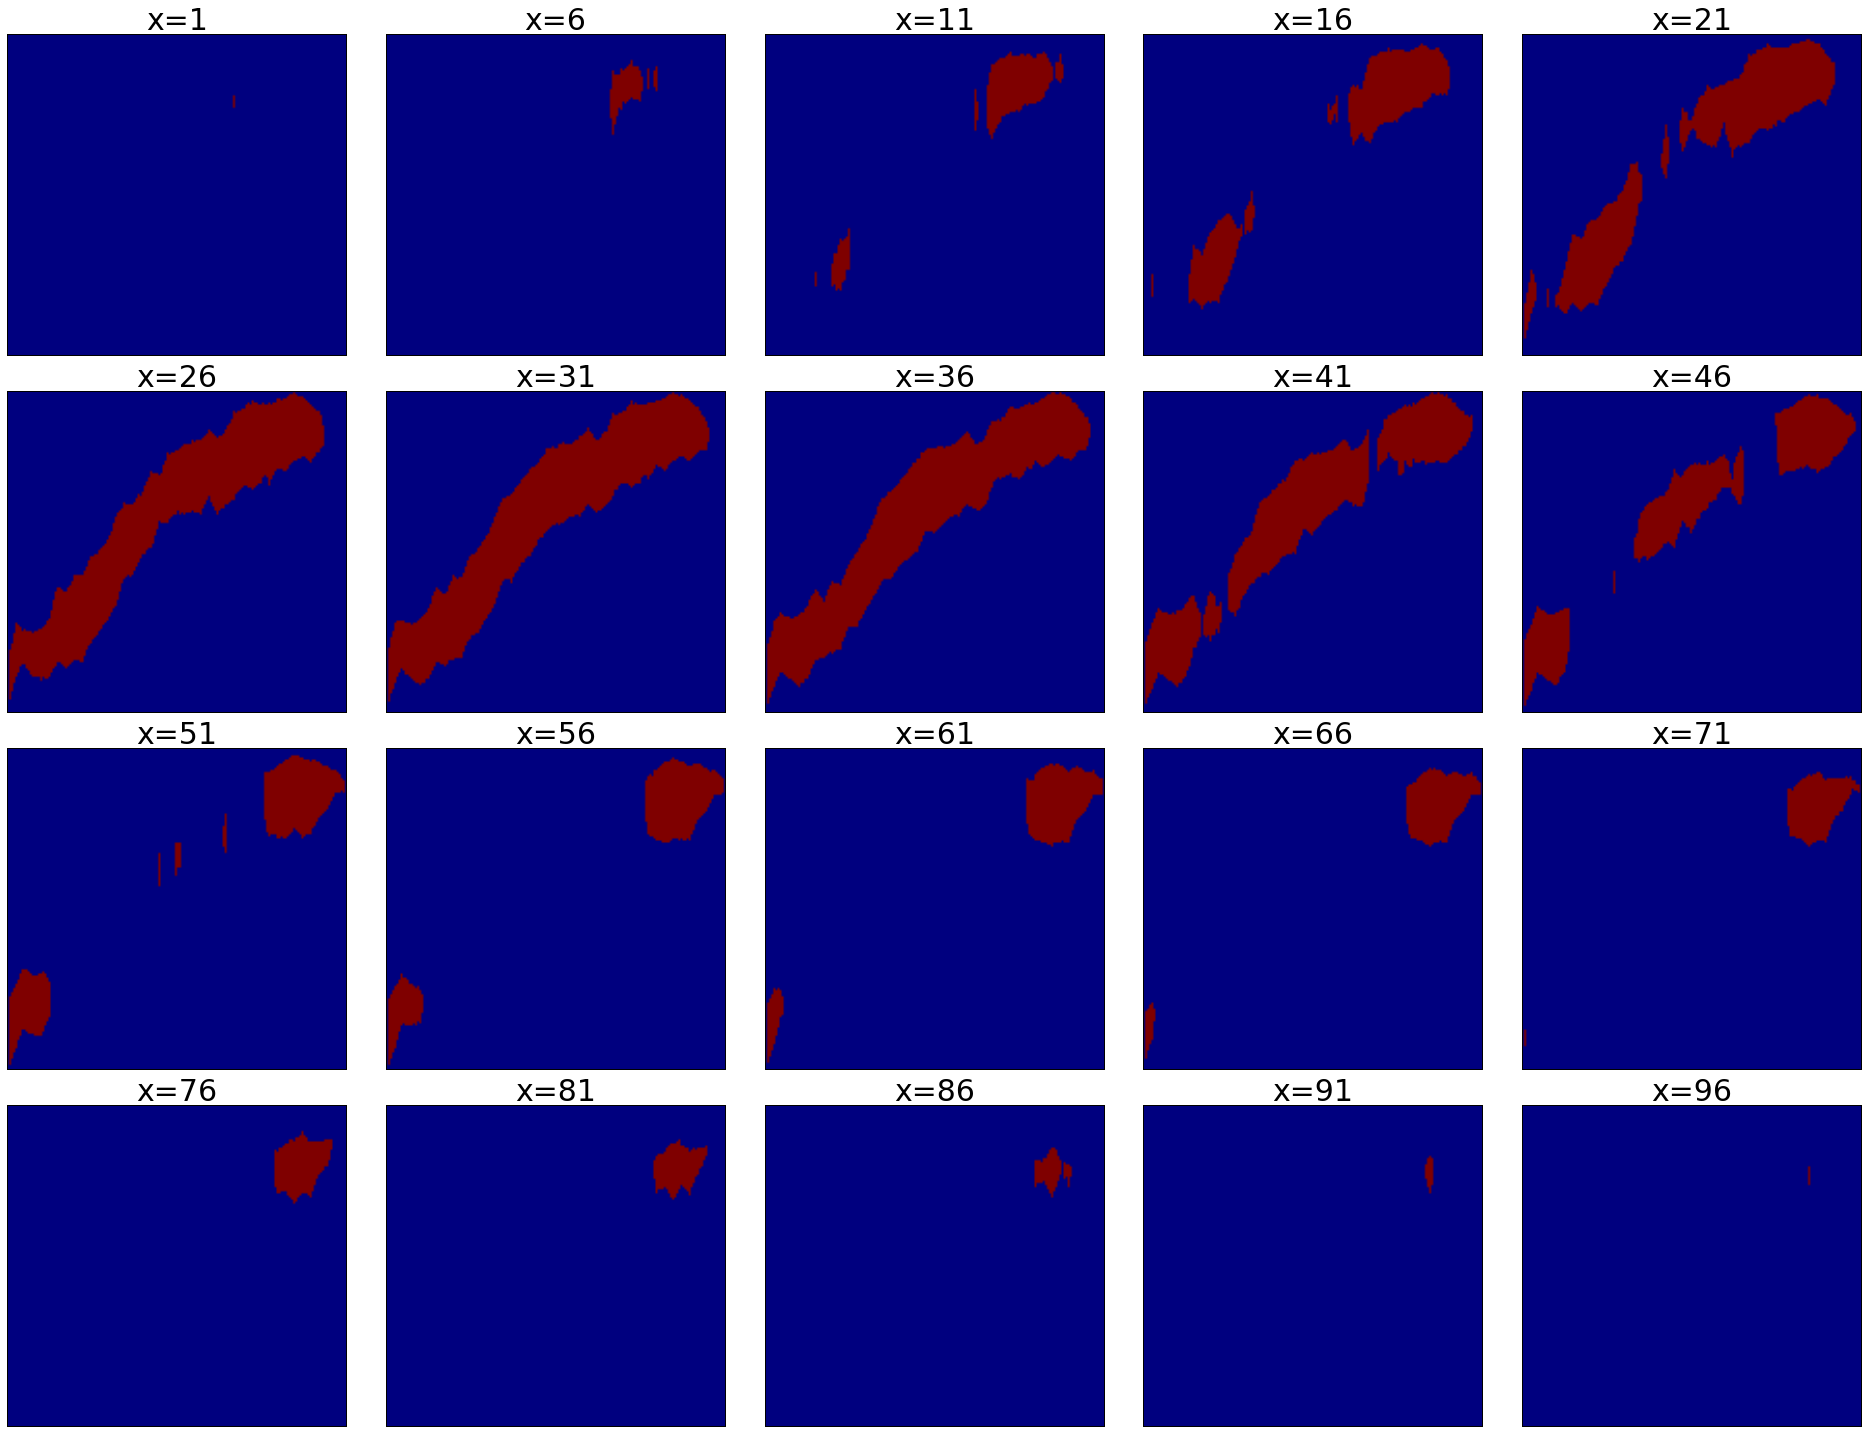

In [23]:
display_volume_sections(vol_bbox_dict['7n_L'][0], direction='x')

In [38]:
polydata_actor_list = []
for name_s in ['7n_R', '7n_L']:
    polydata = volume_to_polydata(vol_bbox_dict[name_s][0], num_simplify_iter=3, smooth=True)
    xmin, _, ymin, _, zmin, _ = vol_bbox_dict[name_s][1]
    polydata_actor = actor_mesh(polydata, origin=(xmin,ymin,zmin), wireframe=True, )
    polydata_actor_list.append(polydata_actor)

marching cube: 0.41 seconds
mesh_to_polydata: 0.06 seconds
simplify 0 @ 47217: 0.56 seconds
simplify 1 @ 9443: 0.49 seconds
simplify 2 @ 1888: 0.10 seconds
marching cube: 0.34 seconds
mesh_to_polydata: 0.05 seconds
simplify 0 @ 38311: 0.42 seconds
simplify 1 @ 7663: 0.33 seconds
simplify 2 @ 1534: 0.08 seconds


In [40]:
launch_vtk(polydata_actor_list + [actor_sphere(position=(0,0,0), radius=10)])